In [1]:
!pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
import seaborn
import string
import re
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer


In [3]:
!pip install nltk


In [4]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.3 MB/s eta 0:00:00


In [5]:
!pip install textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.4 MB/s eta 0:00:00


In [6]:
import nltk
from nltk.stem.porter import *
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
import warnings

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


In [8]:
df=pd.read_csv('/content/labeled_data.csv')
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [9]:
df.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


In [10]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

In [11]:
tweets=df.tweet

In [12]:
#importing list of stopwords
nltk.download('stopwords')
stopwords=nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
exclusions=["#ff", "ff", "rt", "austrian painter"] #add any words you want to ignore
stopwords.extend(exclusions)

In [14]:
stemmer=PorterStemmer() #stemming the words to their based form using Porter algorithm

In [15]:
def preprocess(text):
  #remove urls, mentions adn multiple whitespaces

  spacepattern='\s+'

  urlregex=('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
  mentionregex='@[\w\-]+'

  parsedtext=re.sub(spacepattern, " ", text)
  parsedtext=re.sub(urlregex,"",parsedtext)
  parsedtext=re.sub(mentionregex,"",parsedtext)

  return parsedtext


In [16]:
def tokenize(tweet):
  #We tokenize the weet, remove punctiuation, whitespace, etc and set to small letters,and we stem the tweets

  tweets=" ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
  tokens=[]
  for t in tweets.split():
    tokens.append(stemmer.stem(t))

  return tokens


In [17]:
def tokenizewithoutstemming(tweet):
  tweets=" ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()

  return tweets.split()

In [18]:
#converting data into TFIDF features, that is sying importnace of word in document
'''
parameters:
ngram range: no of contiguous sequence of n words oto be taken from given sample
max features speicifies maxinum number of features or unique words to be extracted fro text, that is words that occur more frequently are given heigher weights
min df and max df specify min and max document frequency that is , control the inclusion of terms that appear too frequently or infrequently
use idf, smoothidf norm are contolling how values are calculated and normalized
'''

vectorizer=TfidfVectorizer(tokenizer=tokenize, preprocessor=preprocess, ngram_range=(1,3), stop_words=stopwords, use_idf=True, smooth_idf=False, norm=None, decode_error='replace', max_features=10000, min_df=5, max_df=0.75)

In [19]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [20]:
#construct tfidf matrix and get scores

tfidf=vectorizer.fit_transform(tweets).toarray() #fitting the vectorizer to ext data and transform to tfidf matrix and then to numpy array
#tfidf contains tfidf matrix row is tweet col is unique word or ngram fe

vocab={}
#map feature names(words or ngrams) to corresponding index in tfidf matrix
featurenames=vectorizer.get_feature_names_out() #get feature names

#enumerate thru feature names and assign index to each feature

for i,v in enumerate(featurenames):
  vocab[v]=i #index i to feature v

idfvals=vectorizer.idf_
idfdict={}
#map feature index to idf score
for featureindex in vocab.values():
  idfdict[featureindex]=idfvals[featureindex]

'''
basically feature names that is words or ngrams are got from vectorize,r each index ssigned feature name, and then vocab contains all feature names as keys, and index correspoinding as values
idfdi t contains mapping of feature index to correspoding idf score'''


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn(


'\nbasically feature names that is words or ngrams are got from vectorize,r each index ssigned feature name, and then vocab contains all feature names as keys, and index correspoinding as values\nidfdi t contains mapping of feature index to correspoding idf score'

In [21]:
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [22]:
#getting part of speech tag
postags=[] #uses pos tags for tweets
for t in tweets:
  tokens=tokenizewithoutstemming(preprocess(t))
  tags=nltk.pos_tag(tokens)
  taglist=[]
  for x in tags:
    taglist.append(x[1])
  tagstring=" ".join(taglist)
  postags.append(tagstring)

In [23]:
#iusing tfidf vecotirzer to get a token matrix for pos tags
#the token matrix is a cloection of text into matrix, where each row represents text and column a unique token ngrma or word extracted fro m thetext data
posvectorizer=TfidfVectorizer(tokenizer=None, lowercase=False, preprocessor=None, ngram_range=(1,3), stop_words=None, use_idf=False, smooth_idf=False, norm=None, decode_error='replace', max_features=5000, min_df=5, max_df=0.75)
#after getting token matrix, the code constructs another matrixrepreosenting pos tags of tweets
#we make another matrix representing pos tags of tweets

pos=posvectorizer.fit_transform(pd.Series(postags)).toarray()

In [24]:
pos_vocab = {v:i for i, v in enumerate(posvectorizer.get_feature_names_out())}

In [25]:
#getting sentiment analysis and other features
sentiment_analyzer=VS()

In [26]:
def countobjects(text):
  '''
  function to count certain media specific objects like url, mentions, hashtags etc
  replaces urls, multiple whitespace, mentions, hasthags, to get standard counts of all these without caring for whos mentioned
  '''

  spacepattern='\s+'
  urlregex=('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
  mentionregex='@[\w\-]+'
  hashtagregex='#[\w\-]+'
  parsedtext=re.sub(spacepattern, ' ', text)
  parsedtext=re.sub(urlregex, 'URL', parsedtext)
  parsedtext=re.sub(mentionregex,'MENTION', parsedtext)
  parsedtext=re.sub(hashtagregex,'HASHTAG',parsedtext)

  return(parsedtext.count('URL'), parsedtext.count('MENTION'), parsedtext.count('HASHTAG'))

In [27]:
def otherfeatures(tweet):
  #We take stirng, and return list of features like sentiment score, readability score

  sentiment=sentiment_analyzer.polarity_scores(tweet)
  words=preprocess(tweet) #getting only text no charcters
  syllables=textstat.syllable_count(words)
  numchars=sum(len(w) for w in words)
  totalnumchars=len(tweet)
  numwords=len(words.split())
  numterms=len(tweet.split())
  avgsyl=round(float((syllables+0.001))/float(numwords+0.001),4)
  numuniqueterms=len(set(words.split()))


  #Modified FK grade, where avg words per sentence is num words/1
  fkra=round(float(0.39*float(numwords)/1.0)+float(11.8*avgsyl)-15.59,1)
  #fre score
  fre=round(206.835-1.015*(float(numwords)/1.0)-(84.6*float(avgsyl)),2)

  mediaobjects=countobjects(tweet)
  retweet=0
  if "rt" in words:
    retweet=1  #can use this feature of retweeting in forum

  features=[fkra, fre, syllables, avgsyl, numchars, totalnumchars, numterms, numuniqueterms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'], mediaobjects[2], mediaobjects[1], mediaobjects[0], retweet]
  return features



In [28]:
def getfeaturearray(tweets):
  features=[]
  for t in tweets:
    features.append(otherfeatures(t))
  return np.array(features)

In [29]:
otherfeatureslist = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [30]:
feat=getfeaturearray(tweets)

In [31]:
#joining everything up
joined=np.concatenate([tfidf, pos, feat], axis=1)

In [32]:
joined.shape

(24783, 3909)

In [33]:
#getting a list of variable names

variables=['']*len(vocab)
for k, v in vocab.items():
  variables[v]=k

posvariables=['']*len(pos_vocab)
for k, v in pos_vocab.items():
  posvariables[v]=k

featurenames=variables+posvariables+otherfeatureslist

In [34]:
x=pd.DataFrame(joined)
y=df['class'].astype(int)

In [35]:
xtrain, xtest, ytrain, ytest=train_test_split(x, y, random_state=42, test_size=0.1)

In [36]:
# pipe=Pipeline([('select', SelectFromModel(LogisticRegression(class_weight='balanced', penalty='l2',C=0.01))), ('model', LogisticRegression(class_weight='balanced', penalty='l2', solver='lbfgs'))])

In [37]:
# paramgrid = {
#     'model__C': [0.01, 0.1, 1.0],  # Regularization parameter values
#     'model__penalty': ['l1', 'l2']  # Type of regularization
# }
# gridsearch=GridSearchCV(pipe, paramgrid, cv=StratifiedKFold(n_splits=5, random_state=None).split(xtrain, ytrain), verbose=2)
# #NOTE random state is set to None, if you want 42, set shuffle as True

#NO NEED TO PIPELINING AS WE WANT FAST

In [38]:
model = LogisticRegression(class_weight='balanced', penalty='l2')


In [39]:
model.fit(xtrain, ytrain)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [40]:
ypred=model.predict(xtest)

In [41]:
report=classification_report(ytest, ypred)


In [42]:
print(report)

              precision    recall  f1-score   support

           0       0.27      0.65      0.38       164
           1       0.95      0.75      0.84      1905
           2       0.58      0.81      0.68       410

    accuracy                           0.76      2479
   macro avg       0.60      0.74      0.63      2479
weighted avg       0.84      0.76      0.78      2479



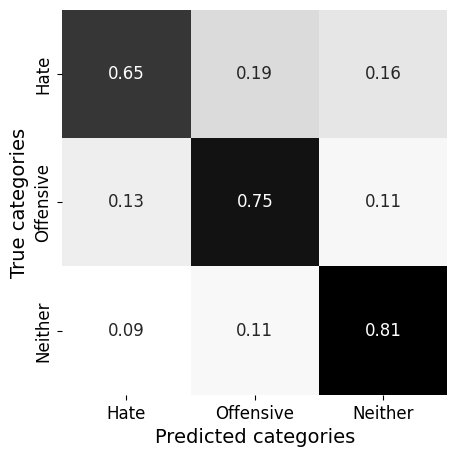

In [43]:
confusion_matrix = confusion_matrix(ytest,ypred)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5, 5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

In [43]:
from google.colab import drive
drive.mount('/content/drive')

In [46]:
# import joblib
# model_path = '/content/drive/My Drive/Colab Notebooks/hatespeechmodel.pkl'
# joblib.dump(model, model_path)


In [48]:
# print(ypred[69])

0
